In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import csv
import os
import sys
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
## Multithreading experiment

from src.vrp.solvers.integer_model import VRPTWSolver
from src.general_optimization_solver import *


instance = load_instance('old/R109.50.json')

In [4]:
solver2 = VRPTWSolver(TimeLimit=1, no_workers=1)
solver2.solve(instance, )

Time limit set to 1 seconds
Building model
Looking for solution
 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 326 variables, 377 constraints
 ! TimeLimit            = 1
 ! Workers              = 1
 ! LogVerbosity         = Terse
 ! Initial process time : 0.03s (0.03s extraction + 0.00s propagation)
 !  . Log search space  : 1593.9 (before), 1593.9 (after)
 !  . Memory usage      : 3.8 MB (before), 3.8 MB (after)
 ! Using sequential search.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed            Branch decision
                        0        326                 -
 + New bound is 412.1999
                        0        226                 -
 + New bound is 422.4970
 *      1738.600       61  0.04s               (gap is 75.70%)
 I Used: 17
 *      1724.500     1194  0.06s               (gap is 75.50%)
 I Used: 16
 *      1705.200     2792  0.11s          

(1492.0,
 {'n_vehicles': 13,
  'total_distance': 1492.0,
  'paths': [[0, 5, 31, 36, 46, 48, 0],
   [0, 11, 3, 9, 50, 0],
   [0, 15, 14, 42, 17, 13, 1, 0],
   [0, 21, 29, 20, 10, 0],
   [0, 33, 7, 30, 0],
   [0, 38, 16, 44, 43, 4, 0],
   [0, 27, 2, 28, 26, 0],
   [0, 35, 34, 0],
   [0, 47, 19, 8, 45, 25, 0],
   [0, 12, 39, 37, 0],
   [0, 23, 6, 18, 0],
   [0, 49, 32, 24, 0],
   [0, 41, 22, 40, 0]]},
 <docplex.cp.solution.CpoSolveResult at 0x1f8d76233c0>)

56 workers and 1 cores, 1020.9 in 57.59 seconds
1 workers and 56 cores, 808.7 in 56.68 seconds
56 workers and 24 cores, 805.1 in 59.8 seconds
24 workers and 24 cores, 802.2 in 49.0 seconds
24 workers and 56 cores, 802.2 in 47.51 seconds


KeyError: 'solver_config'

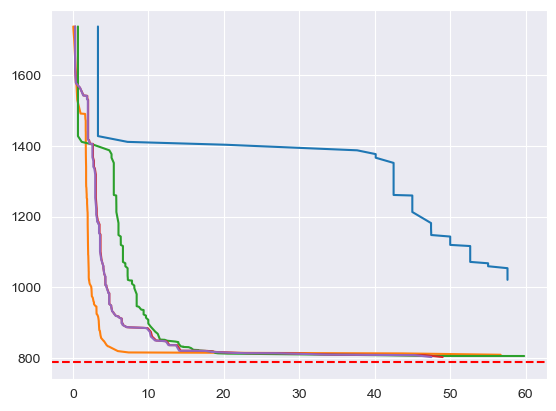

In [5]:

best_known_solution = 786.8
plt.axhline(y=best_known_solution, color='r', linestyle='--', label='Best Known Solution')

for solution in instance._run_history:
    if 'name' in solution.keys():
        # print(solution['n_workers'])
        # print(solution['n_cores'])
        # print(solution['total_distance'])
        print(f'{solution["n_workers"]} workers and {solution["n_cores"]} cores, {solution["total_distance"]} in {solution["search_progress"][-1][1]} seconds')
        numbers = [entry[0] for entry in solution['search_progress']]
        times = [entry[1] for entry in solution['search_progress']]
        plt.plot(times, numbers, label=f'{solution["n_workers"]} workers and {solution["n_cores"]} threads')

add = 2
for solution in instance._run_history[-add:]:
    n_workers = solution['solver_config']['NoWorkers']
    n_cores = solution['solver_config']['NoCores']
    print(f'{n_workers} workers and {n_cores} cores, {solution["solution_value"]} in {solution["solution_progress"][-1][1]} seconds')
    numbers = [entry[0] for entry in solution['solution_progress']]
    times = [entry[1] for entry in solution['solution_progress']]
    plt.plot(times, numbers, label=f'{n_workers} workers and {n_cores} threads')


# Plot the data

plt.ylabel('Value')
plt.xlabel('Time (seconds)')
plt.title('Multithreading experiment')
plt.legend(loc='upper right')

plt.savefig('plots/multithreading_experiment.pdf', format='pdf')

plt.show()

In [49]:
# Load all data into a DataFrame

# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the files in the folder

data_folder = '..\\..\\data\\VRPTW\\'  # Specify the folder name where the data files are located
# cvrptw_prob = VRPTW()

for folder_name in os.listdir(data_folder):
    if not os.path.isdir(os.path.join(data_folder, folder_name)):
        continue
    folder_path = os.path.join(data_folder, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            # Read the JSON file

            id = filename.split('.')[0]+ '.' + folder_name.split('_')[1]
            instance_name = filename.split('.')[0]
            file_path = os.path.join(folder_path, filename)
            with open(file_path) as f:
                data = json.load(f)
                
            # print(f"Processing {id}")

            # Extract the required data from the JSON
            benchmark = data['instance_kind']
            N = data['data']['nb_customers']
            best_known_solution = data['reference_solution']
            # old solutions
            solutions = [{'solver_name': f'{sol["solver"] if "solver" in sol.keys() else "Docplex, integer model"}', 
                    'n_workers': sol['n_workers'] if 'n_workers' in sol.keys() else 0,
                    'total_distance': sol['total_distance'],
                    'number_of_vehicles': sol['n_vehicles'] if 'n_vehicles' in sol.keys() else sol['vehicles'],
                    'timeout': sol['time'],
                    'time': sol['search_progress'][-1][1] if 'search_progress' in sol.keys() else sol['time']}
                    for sol in data['run_history'][:3]]
            # new solutions
            solutions.extend([{'solver_name': sol["solver_name"], 
                    'n_workers': sol['solver_config']['NoWorkers'] if 'NoWorkers' in sol['solver_config'].keys() else 0,
                    'total_distance': sol['solution_info']['total_distance'],
                    'number_of_vehicles': sol['solution_info']['n_vehicles'],
                    'timeout': sol['solve_time'] if isinstance(sol['solve_time'], float) else sol['solve_time'][0],
                    'time': sol['solution_progress'][-1][1]}
                    for sol in data['run_history'][3:]])

            # print(solutions)

            horizon = instance_name[2] if instance_name[:2] == 'RC' else instance_name[1]

            # Create a DataFrame with the extracted data
            df = pd.DataFrame({
                'benchmark': [benchmark],
                'name': [instance_name],
                'N': [N],
                'horizon': 'short' if horizon == '1' else 'long',
                'sampling': 'RC' if instance_name[:2] == 'RC' else instance_name[0],
                'best_known_solution': [best_known_solution],
                'solutions': [solutions]
            })

            # df = df.assign(solutions=[solutions])

            # Append the DataFrame to the list
            dfs.append(df)
            # break

# Concatenate the list of DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

# Display the resulting DataFrame
print(result_df)

#save df

# result_df.to_csv('..\\..\\data\\VRPTW\\result_df.csv', index=False)
result_df.to_json('..\\..\\data\\VRPTW\\result_df.json', orient='records', force_ascii=False, default_handler=str)


    benchmark   name    N horizon sampling             best_known_solution  \
0      CVRPTW   C101  100   short        C  {'optimum': 827.3, 'NV': 10.0}   
1      CVRPTW   C102  100   short        C  {'optimum': 827.3, 'NV': 10.0}   
2      CVRPTW   C103  100   short        C  {'optimum': 826.3, 'NV': 10.0}   
3      CVRPTW   C104  100   short        C  {'optimum': 822.9, 'NV': 10.0}   
4      CVRPTW   C105  100   short        C  {'optimum': 827.3, 'NV': 10.0}   
..        ...    ...  ...     ...      ...                             ...   
163    CVRPTW  RC204   50    long       RC   {'optimum': 444.2, 'NV': 3.0}   
164    CVRPTW  RC205   50    long       RC   {'optimum': 630.2, 'NV': 5.0}   
165    CVRPTW  RC206   50    long       RC   {'optimum': 610.0, 'NV': 5.0}   
166    CVRPTW  RC207   50    long       RC   {'optimum': 558.6, 'NV': 4.0}   
167    CVRPTW  RC208   50    long       RC   {'optimum': 476.7, 'NV': 3.0}   

                                             solutions  
0    [

In [50]:
#load df

# result_df = pd.read_csv('..\\..\\data\\VRPTW\\result_df.csv') - converts arrays and dicts to strings
result_df = pd.read_json('..\\..\\data\\VRPTW\\result_df.json', orient='records')


In [51]:
# Sorting

result_df = result_df.sort_values(by=[ 'N', 'name',])

In [79]:
# DataFrame with data about each solve
solvers_data = []

for index, row in result_df.iterrows():
    best = row['best_known_solution']['optimum']
    solutions = row['solutions']
    solutions.sort(key=lambda x: (x.get('total_distance', float('inf')), x.get('number_of_vehicles', float('inf')), x.get('time', float('inf'))))
    seen_solvers = set()  # Keep track of solvers already added
    for solution in solutions:
        solver_name = solution.get('solver_name', 'Unknown')
        # Only add the best solution for each solver
        if solver_name not in seen_solvers:
            relative_distance = solution.get('total_distance', 0) / best
            time = solution.get('time', 0)
            timeout = solution.get('timeout', False)
            number_of_vehicles = solution.get('number_of_vehicles', 0)
            solvers_data.append({'ID': row['name']+'.'+str(row['N']), 'Name': row['name'], 'N': row['N'], 'horizon': row['horizon'], 'sampling': row['sampling'],
                                 'solver_name': solver_name, 'relative_distance': relative_distance, 'total_distance': solution.get('total_distance', 0),
                                 'time': time, 'timeout': timeout, 'number_of_vehicles': number_of_vehicles})
            seen_solvers.add(solver_name)

solvers = pd.DataFrame(solvers_data)

In [80]:
for s in solvers['solver_name'].unique():
    print(s)

CP Integer Model
Docplex, integer model
GA BRKGA
OR-Tools
GA DE
Docplex, interval model
GA PSO, decode_chromosome_second
GA PSO, min of 2
GA PSO, decode_chromosome_rec
GA PSO, decode_chromosome_fast


In [81]:
# filter by solvers

# solvers = solvers[solvers['solver_name'].str.match('^(Docplex|OR-Tools)')]
solvers = solvers[solvers['solver_name'].str.match('^(Docplex, integer model|GA BRKGA)')]

# remove solvers 
# solvers = solvers[~solvers['solver_name'].str.match('^(GA PSO, decode_chromosome_rec)$')]

#rename solvers
# solvers['solver_name'] = solvers['solver_name'].replace({'GA PSO, decode_chromosome_rec': 'GA PSO, decode_chromosome_rec_pruned'})

In [82]:
unique_solver_names = solvers['solver_name'].unique()
print(unique_solver_names)
custom_palette = sns.color_palette('tab10', n_colors=len(unique_solver_names))

['Docplex, integer model' 'GA BRKGA']


In [83]:
# Great function for better label tics
# y label positions change based on resolution of the plot, the default values are for figsize=(14,7)

def awesome_tics(ax, y_label_abs=0.033, y_label_rel=400):
    ax.set_xticks([])
    ax.xaxis.labelpad = 65
    
    axis = []
    keys = ['N', 'horizon', 'sampling']
    horizons = solvers.get(keys)
    ticss = []
    for key in horizons.keys():
        list_key = horizons.get(key).tolist()
    
        last = list_key[0]
        ax_tics = [last]
        for i in range(1, len(list_key)):
            if list_key[i] != last:
                ax_tics.append(list_key[i])
                last = list_key[i]
        ticss.append(ax_tics)
    
    # order tics by length reverse
    tics_order = np.argsort([len(tics) for tics in ticss],)[::-1]
    for i in tics_order:
        ax_tics = ticss[i]
        key = keys[i]
        if len(ax_tics) == len(solvers['ID'].unique()):
            continue
    
        ax_tics.append('')
    
        # tics = np.linspace(start=0, stop=len(result_df), num=len(ax_tics))
    
        axis.append(ax.twiny())
        newax = axis[-1]
        # newax.set_frame_on(True)
        # newax.patch.set_visible(False)
        newax.xaxis.set_ticks_position('bottom')
        newax.xaxis.set_label_position('bottom')
        xoffset = 20 * (len(axis) - 1)
        newax.spines['bottom'].set_position(('outward', xoffset))
        newax.annotate(key + ':', xy=(-0.01, -(xoffset/y_label_rel) - y_label_abs), xytext=(5, 0), ha='right', xycoords='axes fraction', textcoords='offset points')
    
        atics = np.linspace(start=0, stop=len(result_df), num=len(ax_tics))
        newax.set_xticks(atics, labels=ax_tics, )
        ax_tics=ax_tics[:-1]
        tics = np.linspace(start=0, stop=len(result_df), num=(len(ax_tics)*2)+1)
        tics = tics[1::2]
        newax.set_xticks(tics, labels=ax_tics, minor=True)
        newax.xaxis.set_major_formatter(ticker.NullFormatter())
        newax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
        # for label in newax.get_xticklabels():
        #     label.set_horizontalalignment('center')
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.08)

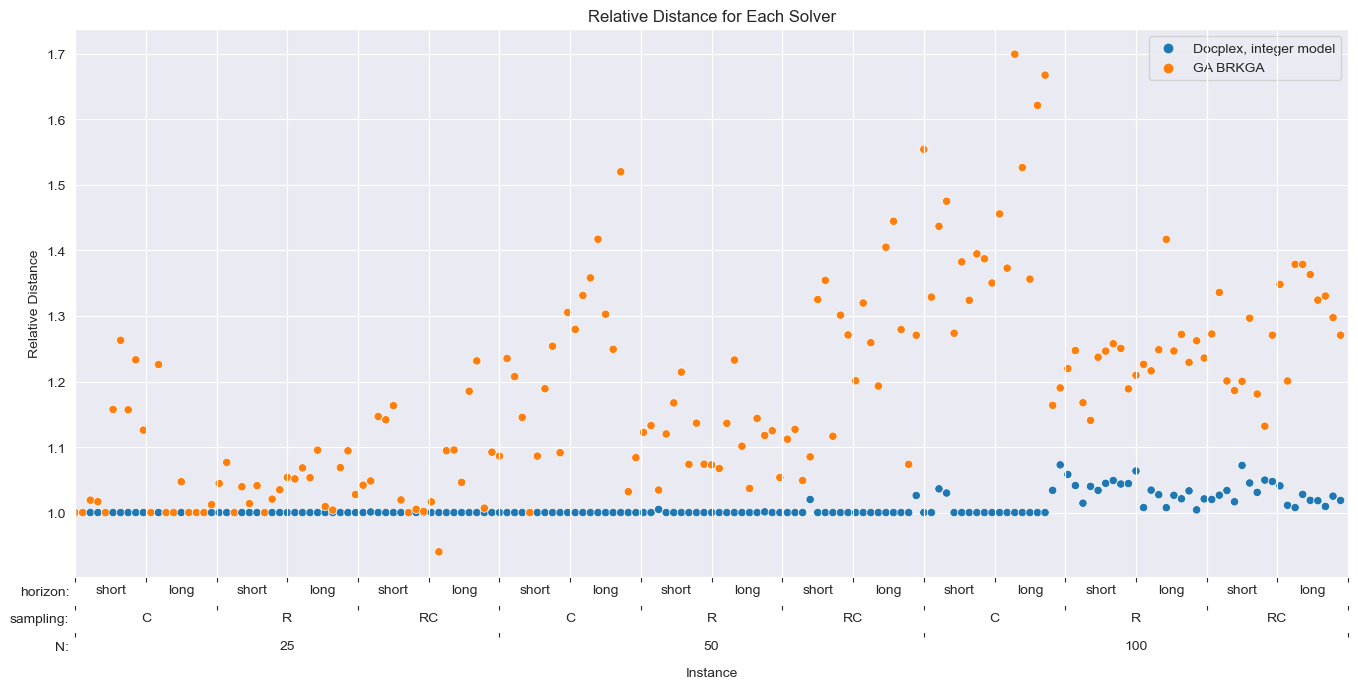

In [84]:
# Plot total distance from solutions

fig, ax = plt.subplots(figsize=(14,7))
ax.set_xlim([0, len(result_df)])

sns.scatterplot(data=solvers, x='ID', y='relative_distance', hue='solver_name', palette=custom_palette)
plt.xlabel('Instance')
plt.ylabel('Relative Distance')
plt.title('Relative Distance for Each Solver')
ax.legend()
# print x tics
# tics = ax.get_xticklabels()
# names = result_df['name']+'.'+result_df['N'].astype(str).values
# for tic, name in zip(tics, names):
#     print(tic, name)

awesome_tics(ax)

plt.savefig('plots/relative_distance.png')
plt.show()


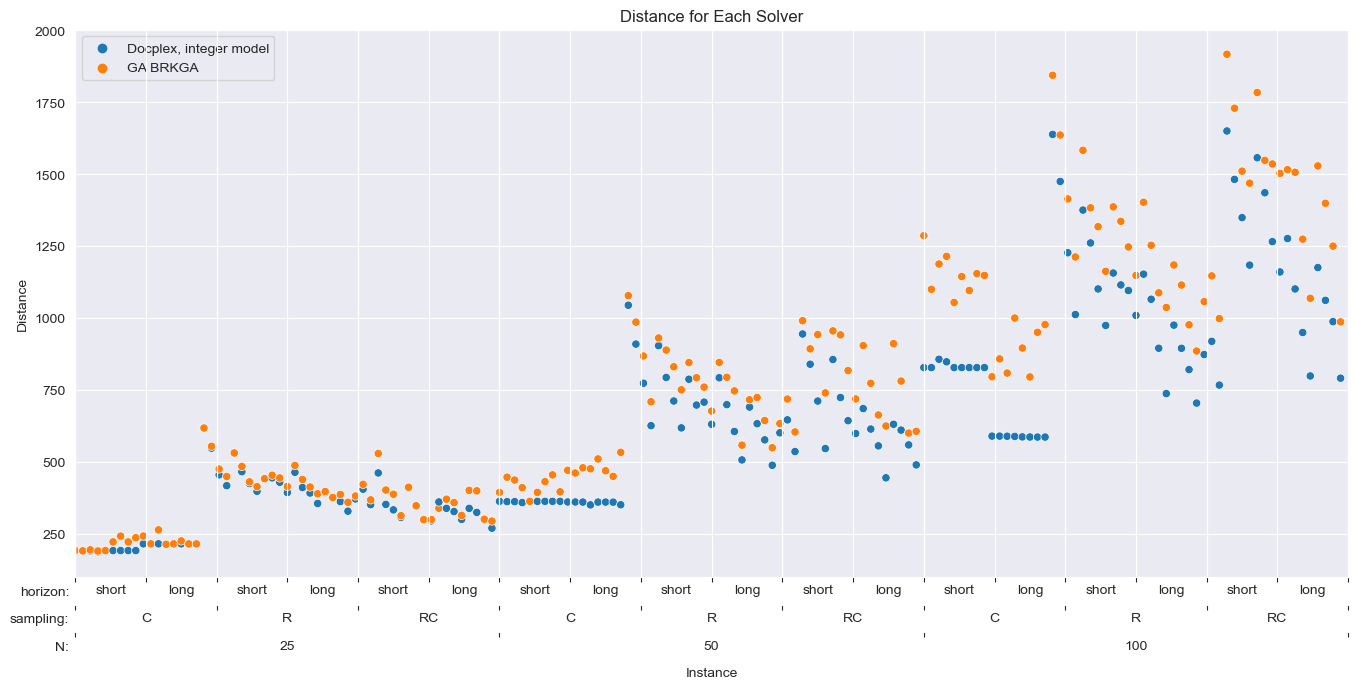

In [85]:
# Plot total distance from solutions

fig, ax = plt.subplots(figsize=(14,7))
ax.set_xlim([0, len(result_df)])

sns.scatterplot(data=solvers, x='ID', y='total_distance', hue='solver_name', palette=custom_palette)
plt.xlabel('Instance')
plt.ylabel('Distance')
plt.title('Distance for Each Solver')
ax.legend()
# print x tics
# tics = ax.get_xticklabels()
# names = result_df['name']+'.'+result_df['N'].astype(str).values
# for tic, name in zip(tics, names):
#     print(tic, name)

awesome_tics(ax)

plt.savefig('plots/distance.png')
plt.show()


In [86]:
# print how many times each solver has the best result

# Group the data by solver and count the number of times each solver has the best result
best_results = solvers[solvers['relative_distance'] < 1.005].groupby('solver_name')['relative_distance'].count().sort_values()

print(best_results)

solver_name
GA BRKGA                   17
Docplex, integer model    126
Name: relative_distance, dtype: int64


In [87]:
# print how many times each solver has the best result

# Group the data by solver and count the number of times each solver has the best result
worst_results = solvers[solvers['relative_distance'] > 1.5]

worst_results2 = worst_results.groupby('solver_name')['relative_distance'].count().sort_values(ascending=False)
print(worst_results2)


print(worst_results)

solver_name
GA BRKGA    6
Name: relative_distance, dtype: int64
            ID  Name    N horizon sampling solver_name  relative_distance  \
707    C208.50  C208   50    long        C    GA BRKGA           1.520114   
1067  C101.100  C101  100   short        C    GA BRKGA           1.554212   
1175  C204.100  C204  100    long        C    GA BRKGA           1.699541   
1184  C205.100  C205  100    long        C    GA BRKGA           1.526603   
1202  C207.100  C207  100    long        C    GA BRKGA           1.621543   
1211  C208.100  C208  100    long        C    GA BRKGA           1.667634   

      total_distance    time  timeout  number_of_vehicles  
707            532.8  437.59   900.15                   5  
1067          1285.8  832.07   900.03                  16  
1175           999.5  384.78   900.09                   7  
1184           895.2  897.49   900.29                   9  
1202           949.9  629.81   900.16                   8  
1211           976.9  829.56   900.3

In [88]:
# Group the results by horizon, sampling, and N
grouped_results = solvers.groupby(['horizon', 'sampling', 'N', 'solver_name'])

# Calculate statistics for each group
grouped_stats = grouped_results.agg({'relative_distance': 'mean', 'time': 'mean', 'number_of_vehicles': 'mean', 'Name': 'first'}).reset_index()
grouped_stats = grouped_stats.sort_values(by=['N', 'sampling', 'horizon', 'solver_name'])

# Add an ID column
grouped_stats['ID'] = grouped_stats.apply(lambda row: f"{row['horizon']}-{row['sampling']}-{row['N']}", axis=1)

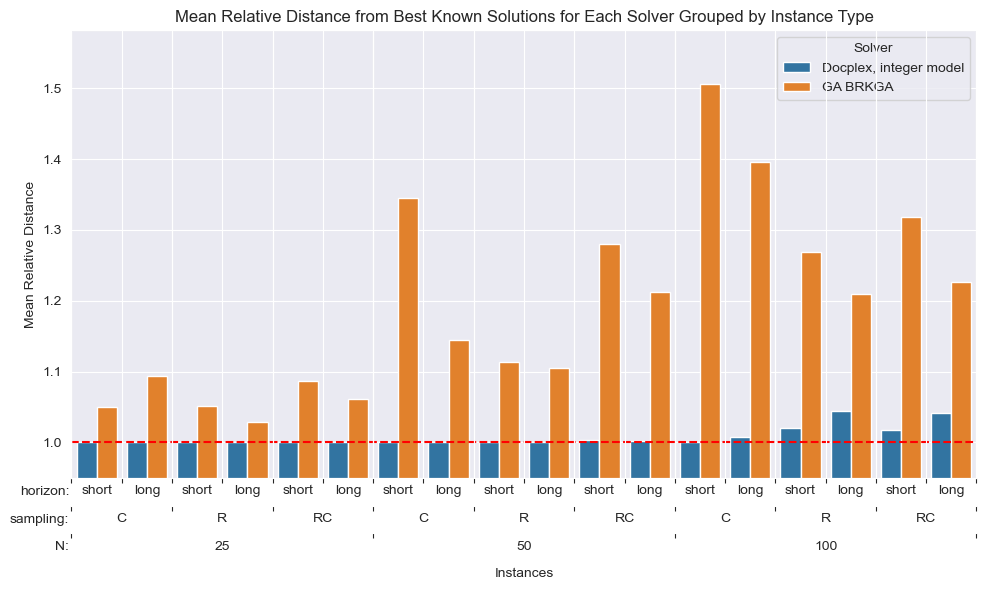

In [89]:
# Find the lowest value
lowest_value = grouped_stats['relative_distance'].min()

# Plot the data
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=grouped_stats, x='ID', y='relative_distance', hue='solver_name', palette=custom_palette)
plt.xlabel('Instances')
plt.ylabel('Mean Relative Distance')
plt.title('Mean Relative Distance from Best Known Solutions for Each Solver Grouped by Instance Type')
plt.xticks(rotation=90)
plt.legend(title='Solver') 
plt.ylim(0.95) 
plt.axhline(y=1, color='r', linestyle='--')

awesome_tics(ax, y_label_abs=0.039, y_label_rel=325)

plt.savefig('plots/relative_distance_grouped.pdf', format='pdf')
plt.show()


In [90]:
# print sum of all distances for each solver

# Group the data by solver and compute the sum of the relative distance for each solver

solver_distance = solvers.groupby('solver_name')['total_distance'].sum().sort_values()
print(solver_distance)

solver_name
Docplex, integer model    106721.2
GA BRKGA                  127392.5
Name: total_distance, dtype: float64


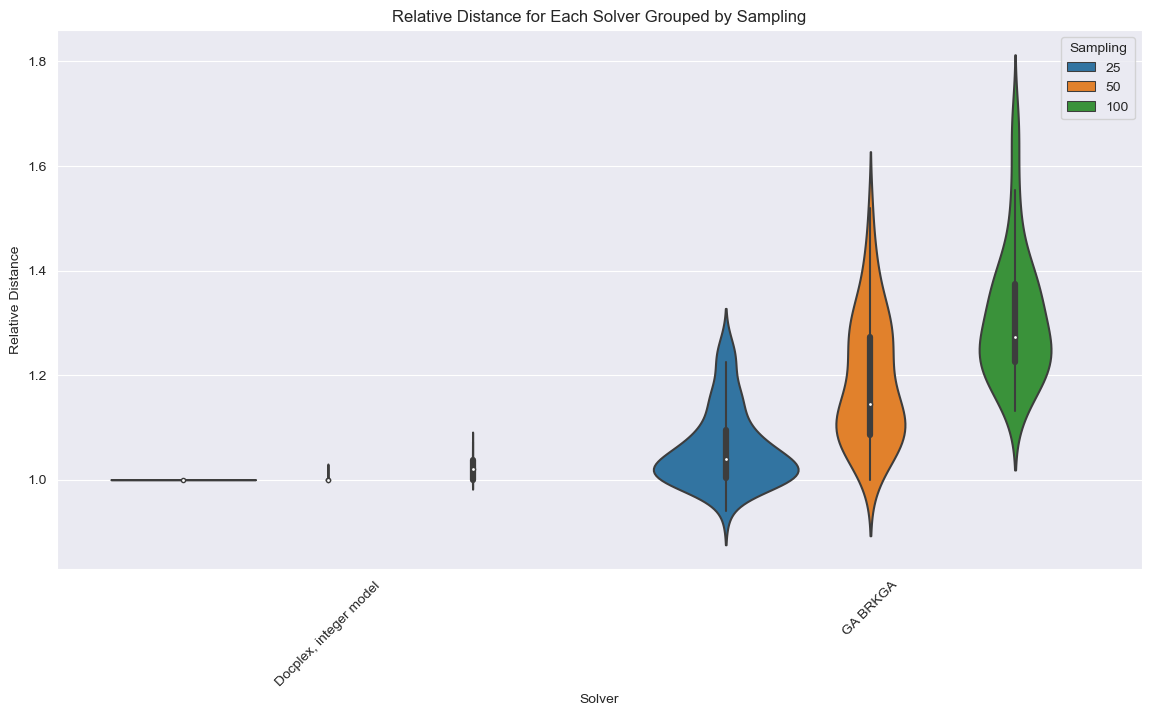

In [91]:
# violin plot for each solver and type

fig, ax = plt.subplots(figsize=(14,7))
sns.violinplot(data=solvers, x='solver_name', y='relative_distance', hue='N', palette='tab10')
plt.ylabel('Relative Distance')
plt.xlabel('Solver')
plt.title('Relative Distance for Each Solver Grouped by Sampling')
plt.legend(title='Sampling')
plt.xticks(rotation=45)
plt.show()


In [92]:
# print sum of all distances for each solver

# Group the data by solver and compute the sum of the relative distance for each solver

solver_distance = solvers.groupby('solver_name')['total_distance'].sum().sort_values()

# Print the results
print(solver_distance)

solver_name
Docplex, integer model    106721.2
GA BRKGA                  127392.5
Name: total_distance, dtype: float64


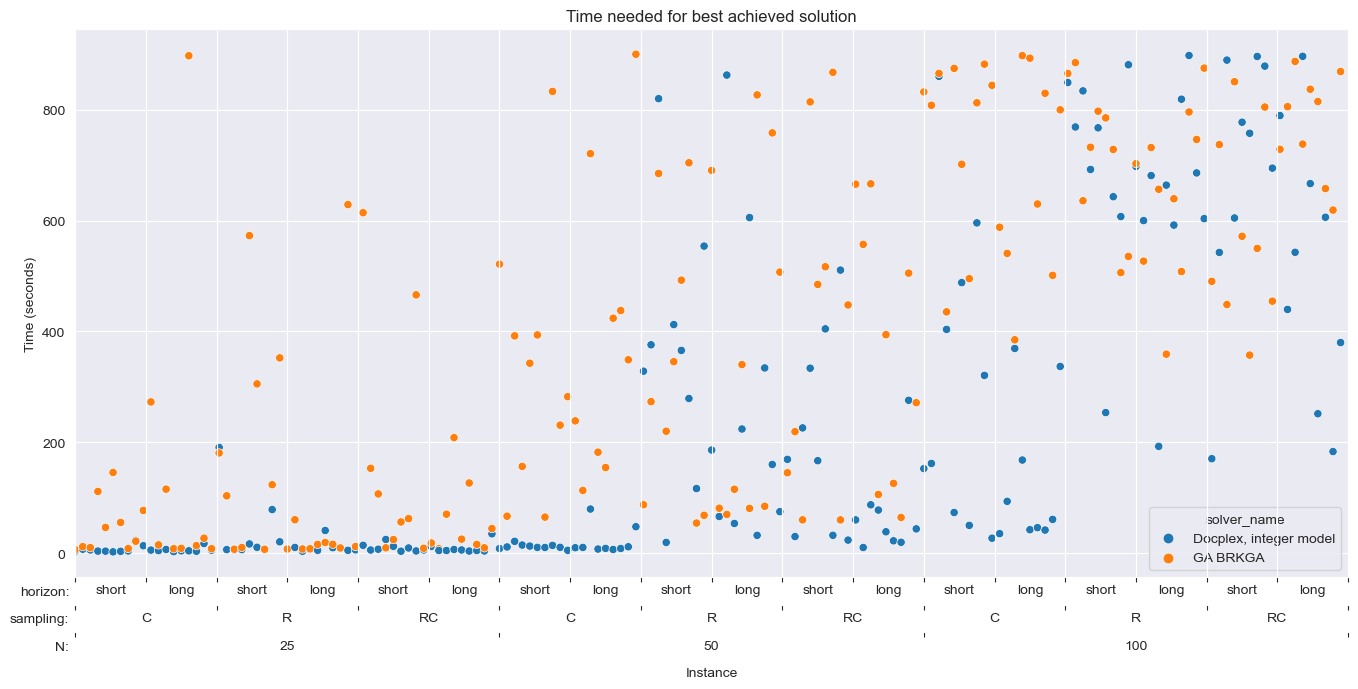

In [93]:
# Plot total time from solutions

fig, ax = plt.subplots(figsize=(14,7))
ax.set_xlim([0, len(result_df)])
sns.scatterplot(data=solvers, x='ID', y='time', hue='solver_name', palette=custom_palette)

# plt.yscale('log')

plt.ylabel('Time (seconds)')
plt.xlabel('Instance')
plt.title('Time needed for best achieved solution')
# ax.legend()

awesome_tics(ax)

plt.savefig('plots/time.png')
plt.show()


In [94]:
# print average time for each solver

# Group the data by solver and compute the average time for each solver

solver_time = solvers.groupby('solver_name')['time'].mean().sort_values()

# Print the results
print(solver_time)

solver_name
Docplex, integer model    222.922798
GA BRKGA                  389.424643
Name: time, dtype: float64


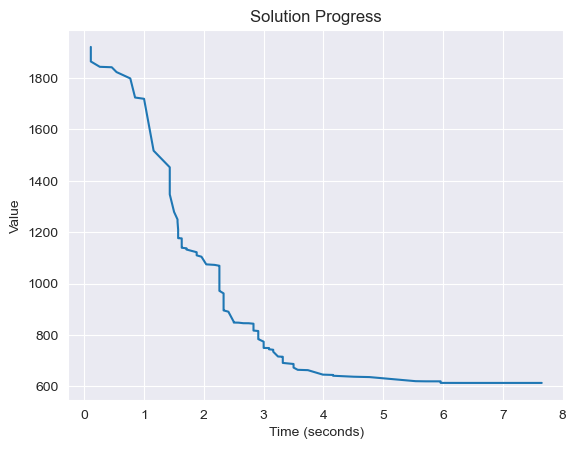

In [95]:
# Visualize solution progress of the last solution

path = '..\\..\\data\\VRPTW\\solomon_50\\RC202.json'

with open(path) as f:
    data = json.load(f)

# Extract the required data from the JSON
solutions = data['run_history']
solution = solutions[3]

# Plot the data

plt.plot([entry[1] for entry in solution['solution_progress']], [entry[0] for entry in solution['solution_progress']])
plt.ylabel('Value')
plt.xlabel('Time (seconds)')
plt.title('Solution Progress')
plt.savefig('plots/solution_progress_example.pdf', format='pdf')
plt.show()


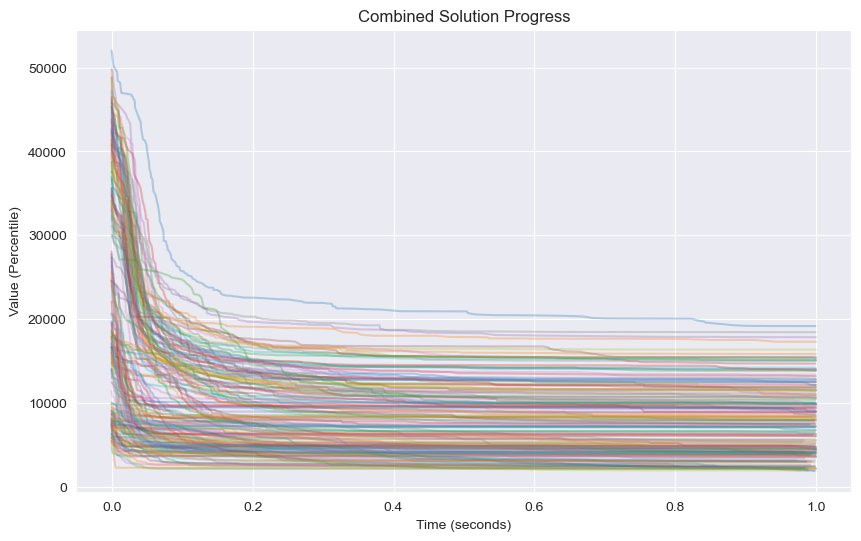

In [96]:
# Function to transform values into percentiles
def transform_to_percentiles(values):
    min_val = min(values)
    max_val = max(values)
    return [(val - min_val) / (max_val)  for val in values]

# Path to the folder containing instance files
folder_path = '..\\..\\data\\VRPTW'

# List to store all solution progress data
all_solution_progress = []

# Iterate through each instance file in the folder
for folder in os.scandir(folder_path):
    if folder.is_dir():
        for filename in os.listdir(os.path.join(folder_path, folder)):
            if filename.endswith('.json'):
                path = os.path.join(folder_path, folder, filename)
                with open(path) as f:
                    data = json.load(f)
                # Extract solution progress data
                solutions = data['run_history']
                solution = solutions[-1]
                solution_progress = solution['solution_progress']
                # Transform values into percentiles
                transformed_progress = [(entry[0], percentile) for entry, percentile in zip(solution_progress, transform_to_percentiles([entry[1] for entry in solution_progress]))]
                all_solution_progress.append(transformed_progress)

# Plot the data
plt.figure(figsize=(10, 6))
for solution_progress in all_solution_progress:
    x = [entry[1] for entry in solution_progress]
    y = [entry[0] for entry in solution_progress]
    plt.plot(x, y, alpha=0.3)  # Adjust transparency here
plt.ylabel('Value (Percentile)')
plt.xlabel('Time (seconds)')
plt.title('Combined Solution Progress')
plt.show()

- Analysis of Best Known Results

In [97]:
import math
import pandas as pd

# Load the CSV file
res_path = "..\\..\\data\\VRPTW\\best.csv"
df = pd.read_csv(res_path, sep=';', header=None, encoding='ISO-8859-1')

# Extract sources and problem labels
sources = df.iloc[0, ::5].reset_index(drop=True)
problem_labels = df.iloc[1, ::5].reset_index(drop=True)

# Extract results
problems = df.iloc[2:, ::5].reset_index(drop=True)
nv = df.iloc[2:, 1::5].reset_index(drop=True)
dist = df.iloc[2:, 2::5].reset_index(drop=True)

print(len(sources))
print(len(problem_labels))
print(problems.shape)
print(nv.shape)
print(dist.shape)


# Initialize an empty DataFrame to store the final results
data = []

# Iterate over each source, problem, NV, and Distance to extract the data
for i in range(len(sources)):
    source = sources[i]
    for problem, nv_value, dist_value in zip(problems.iloc[:, i], nv.iloc[:, i], dist.iloc[:, i]):
        # check if problem is not empty string
        if not isinstance(problem, str) and math.isnan(problem):
            continue
        # remove spaces
        problem = problem.strip()
        if '.' not in problem:
            problem += '.100'
        if isinstance(dist_value, str) and ',' in dist_value:
            dist_value = dist_value.replace(',', '.')
        if isinstance(nv_value, str) and not isinstance(nv_value, float):
            nv_value = int(nv_value)
        # problem to capital letters
        problem = problem.upper()
        data.append([source, problem, nv_value, float(dist_value)])

# Create the DataFrame
final_df = pd.DataFrame(data, columns=['Source', 'Instance', 'NV', 'Distance'])

print(final_df)

28
28
(168, 28)
(168, 28)
(168, 28)
        Source   Instance    NV  Distance
0        GIT 1   C101.100  10.0    828.90
1        GIT 1   C102.100  10.0    828.90
2        GIT 1   C103.100  10.0    828.10
3        GIT 1   C104.100  10.0    825.60
4        GIT 1   C105.100  10.0    828.90
...        ...        ...   ...       ...
2833  Random 2  RC204.100   NaN   1501.48
2834  Random 2  RC205.100   NaN   2239.37
2835  Random 2  RC206.100   NaN   1911.61
2836  Random 2  RC207.100   NaN   2055.97
2837  Random 2  RC208.100   NaN   1483.66

[2838 rows x 4 columns]


In [98]:
# compute relative distance to best known solution

# Group the data by instance and find the minimum distance for each instance
min_distances = final_df.groupby('Instance')['Distance'].min()

# Compute relative distance for each distance value within each instance group
final_df['Relative Distance'] = final_df.apply(lambda row: row['Distance'] / min_distances[row['Instance']], axis=1)


In [99]:
# Group the results by instance
grouped_results = final_df.groupby('Instance')

# Define a function to print the results for each instance
def print_results(group):
    print(f"Instance: {group.name}")
    # Sort the group by distance
    sorted_group = group.sort_values(by='Distance')
    for index, row in sorted_group.iterrows():
        print(f"    Source: {row['Source']}, Distance: {row['Distance']}, NV: {row['NV']}")
    print()

# Apply the function to each group
grouped_results.apply(print_results)


Instance: C101.100
    Source: http://hjemmesider.diku.dk/~spooren/solomon/r1r2solu.htm, Distance: 827.3, NV: 10.0
    Source: http://web.cba.neu.edu/~msolomon/c1c2solu.htm, Distance: 827.3, NV: 10.0
    Source: Optimal value 2, Distance: 827.3, NV: nan
    Source: http://vrp.atd-lab.inf.puc-rio.br/index.php/en/, Distance: 827.3, NV: nan
    Source: Optimal value, Distance: 827.3, NV: nan
    Source: GIT 1, Distance: 828.9, NV: 10.0
    Source: GIT 2, Distance: 828.9, NV: 10.0
    Source: GIT 3, Distance: 828.9, NV: 10.0
    Source: ACO-TS, Distance: 828.93, NV: 10.0
    Source: https://sun.aei.polsl.pl//~zjc/best-solutions-solomon.html, Distance: 828.93664, NV: 10.0
    Source: Random, Distance: 828.937, NV: nan
    Source: SPOT, Distance: 828.937, NV: nan
    Source: ParamILS, Distance: 828.937, NV: nan
    Source: HSFLA, Distance: 828.94, NV: 10.0
    Source: S-PSO, Distance: 828.94, NV: 10.0
    Source: PITSH, Distance: 828.94, NV: 10.0
    Source: CPLA, Distance: 828.94, NV: 10.0


""


In [100]:
for source1 in sources:
    df1 = final_df[final_df['Source'] == source1]
    for source2 in sources:
        if source1 == source2:
            continue
        df2 = final_df[final_df['Source'] == source2]
        if df1['Distance'].values.tolist() == df2['Distance'].values.tolist():
            print(f"Source {source1} and {source2} have the same instances")

Source Optimal value and Optimal value 2 have the same instances
Source Optimal value 2 and Optimal value have the same instances


In [101]:
# which source has the lowest relative distance average

# Group the data by source and compute the average relative distance for each source
source_relative_distance = final_df.groupby('Source')['Relative Distance'].sum().sort_values()

# Print the results
print(source_relative_distance)

Source
http://vrp.atd-lab.inf.puc-rio.br/index.php/en/                   56.224811
GIT 2                                                             56.650350
MFGA                                                              56.926866
GIT 3                                                             57.907458
CPLA                                                              58.471164
ACO-TS                                                            58.636006
GIT 1                                                             58.654940
https://www.sintef.no/projectweb/top/vrptw/100-customers/         58.855656
https://sun.aei.polsl.pl//~zjc/best-solutions-solomon.html        58.856156
HSFLA                                                             58.861909
PITSH                                                             58.864696
S-PSO                                                             60.590006
https://www.preprints.org/manuscript/202206.0074/v1               82.899055
https

In [102]:
# how many times has each source the best result by counting the number of times each source has the relative distance equal to 1

# Group the data by source and count the number of times each source has the relative distance equal to 1
best_results = final_df[final_df['Relative Distance'] == 1].groupby('Source')['Relative Distance'].count().sort_values()

# Print the results
print(best_results)

Source
ACO-TS                                                        1
MFGA                                                          8
http://vrp.atd-lab.inf.puc-rio.br/index.php/en/              48
https://www.preprints.org/manuscript/202206.0074/v1          61
http://web.cba.neu.edu/~msolomon/c1c2solu.htm               138
Optimal value                                               140
Optimal value 2                                             140
http://hjemmesider.diku.dk/~spooren/solomon/r1r2solu.htm    154
Name: Relative Distance, dtype: int64


In [103]:
# print all results where source is https://www.diva-portal.org/smash/get/diva2:419232/FULLTEXT01.pdf - old  

temp = final_df[final_df['Source'] == 'https://www.diva-portal.org/smash/get/diva2:419232/FULLTEXT01.pdf - old']

In [104]:
folder = "..\\..\\data\\VRPTW\\"

for subfolder in os.listdir(folder):
    if not os.path.isdir(os.path.join(folder, subfolder)):
        continue
    for file in os.listdir(os.path.join(folder, subfolder)):
        if file.endswith('.json'):
            instance_name = file.split('.')[0] + '.' + subfolder.split('_')[1]
            results = final_df[final_df['Instance'] == instance_name]
            # sort by distance and nv
            results = results.sort_values(by=['Distance', 'NV'])
            best = results.iloc[0]
            print(instance_name, best['Distance'], best['NV'])
            
            # open file 
            with open(os.path.join(folder, subfolder, file), 'r') as f:
                data = json.load(f)
            
            data['reference_solution'] = {
                'optimum': best['Distance'],
                'NV': best['NV']
            }
            
            # save file
            with open(os.path.join(folder, subfolder, file), 'w') as f:
                json.dump(data, f, indent=4)

C101.100 827.3 10.0
C102.100 827.3 10.0
C103.100 826.3 10.0
C104.100 822.9 10.0
C105.100 827.3 10.0
C106.100 827.3 10.0
C107.100 827.3 10.0
C108.100 827.3 10.0
C109.100 827.3 10.0
C201.100 589.1 3.0
C202.100 589.1 3.0
C203.100 588.7 3.0
C204.100 588.1 3.0
C205.100 586.4 3.0
C206.100 586.0 3.0
C207.100 585.8 3.0
C208.100 585.8 3.0
R101.100 1584.0 19.0
R102.100 1374.2 16.0
R103.100 1158.9 13.0
R104.100 971.5 11.0
R105.100 1355.3 15.0
R106.100 1212.1 13.0
R107.100 1064.6 11.0
R108.100 932.1 10.0
R109.100 1101.99 12.0
R110.100 1068.0 12.0
R111.100 1048.7 12.0
R112.100 948.6 10.0
R201.100 1143.2 8.0
R202.100 1029.6 8.0
R203.100 870.8 6.0
R204.100 731.3 nan
R205.100 949.8 5.0
R206.100 875.9 5.0
R207.100 794.0 4.0
R208.100 701.0 nan
R209.100 854.8 9.0
R210.100 900.5 6.0
R211.100 746.7 nan
RC101.100 1595.9 15.0
RC102.100 1457.4 14.0
RC103.100 1258.0 11.0
RC104.100 1132.3 10.0
RC105.100 1510.1 15.0
RC106.100 1367.2 13.0
RC107.100 1207.8 12.0
RC108.100 1114.2 11.0
RC201.100 1261.8 9.0
RC202.100 

------------
GA heuristic analysis

In [105]:
import os
import time

from src.vrp.solvers.ga_model import *
from src.vrp.problem import *

decoders = [decode_chromosome_fast, decode_chromosome_second, decode_chromosome_rec_pruned_less2, decode_chromosome_rec_pruned_less]

# decoders2 = [decode_chromosome_rec_pruned_less]

folder1 = "..\\..\\data\\VRPTW"

res = []

for folder in os.listdir(folder1):
    if not os.path.isdir(os.path.join(folder1, folder)):
        continue
    for file in os.listdir(os.path.join(folder1, folder)):
        if file.endswith('.json'):
            instance_name = file.split('.')[0] + '.' + folder.split('_')[1]
            path = os.path.join(folder1, folder, file)
            instance = load_instance(path)
            
            # convert to chromosome
            sol = instance._run_history[3]['solution_info']
            dist = sol['total_distance']
            paths = sol['paths']
            print(f"Processing {instance_name}, optimum: {dist}")
            
            # flatten paths and remove all 0
            chromosome = [customer for path in paths for customer in path if customer != 0]
            # print(f"Original length: {dist}\n{paths}")
            # print(f"Chromosome: {chromosome}")
            
            for decoder in decoders:
                start = time.perf_counter()
                routes, length = decoder(instance, chromosome)
                validate_path({'paths':routes}, instance)
                length /= 10
                tim = time.perf_counter() - start
                print(f"Decoder: {decoder.__name__}, Time: {round(tim, 3)}, Length: {length}, Failed: {length != dist}")
                # times[file+'-'+decoder.__name__] = time.perf_counter() - start
                res.append({'instance': file.split('.')[0], 'N': folder.split('_')[1], 'decoder': decoder.__name__, 'time': tim, 'original_dist': dist, 'new_dist': length, 'relative': length/dist 'routes': routes})

# res to df
import pandas as pd
df = pd.DataFrame(res)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1195733601.py, line 43)

In [ ]:
# print results
print(df)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# fail a results if it is more than 1% from the original distance
df['failed'] = df['new_dist'] > df['original_dist'] * 1.05

In [ ]:
df_sorted = df.sort_values(by=['instance', 'decoder'])

# Plotting original distance vs. new distance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sorted, x='original_dist', y='new_dist', hue='decoder', style='failed')
plt.plot([df_sorted['original_dist'].min(), df_sorted['original_dist'].max()], 
         [df_sorted['original_dist'].min(), df_sorted['original_dist'].max()], 
         color='gray', linestyle='--')
plt.title('Original Distance vs. New Distance by Decoder')
plt.xlabel('Original Distance')
plt.ylabel('New Distance')
plt.legend(title='Decoder', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Plotting decode time by decoder
plt.figure(figsize=(10, 6))
sns.barplot(data=df_sorted, x='decoder', y='time', estimator=sum)
plt.yscale('log')
plt.title('Decode Time by Decoder')
plt.xlabel('Decoder')
plt.ylabel('Decode Time')
plt.legend(title='Failed', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

# Plotting failure rate by decoder
plt.figure(figsize=(10, 6))
sns.barplot(data=df_sorted, x='decoder', y='failed', estimator=lambda x: sum(x) / len(x))
plt.title('Failure Rate by Decoder')
plt.xlabel('Decoder')
plt.ylabel('Failure Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

In [ ]:
fail_counts = df_sorted.groupby('decoder')['failed'].sum()

# Print the number of fails for each decoder
print("Number of fails for each decoder:")
for decoder, fails in fail_counts.items():
    print(f"{decoder}: {fails}")

In [ ]:
# analyse time difference for each N and decoder

# Group the data by N and decoder and compute the average time difference for each group
grouped_results = df.groupby(['N', 'decoder'])['time'].sum().reset_index()

# Print the results
print(grouped_results)

In [ ]:
# sum distance difference for each N and decoder
mean_dist = df.groupby(['N', 'decoder'])['new_dist'].sum().reset_index()

print(mean_dist)

In [ ]:
instance = load_instance('..\\..\\data\\VRPTW\\solomon_25\\C102.json')
sol = instance._run_history[-1]['solution_info']
dist = sol['total_distance']
paths = sol['paths']
print(f"Processing {instance}, optimum: {dist}")
chromosome = [customer for path in paths for customer in path if customer != 0]
routes, length = decode_chromosome_second(instance, chromosome)
print(routes)
validate_path({'paths':routes}, instance)
visualize_path({'paths':routes}, instance)

In [ ]:
# Visualize search progress

size = 50
path = '..\\..\\data\\VRPTW\\solomon_' + str(size)

targets = ['GA BRKGA', 'GA DE', 'GA PSO, min of 2', 'Cplex']
progress = {t:[] for t in targets}

for file in os.listdir(path):
    if file.endswith('.json'):
        with open(os.path.join(path, file), 'r') as f:
            data = json.load(f)
            
        temp = data['run_history'][0]['search_progress']
                
        # we need temp to be relative to the best solution
        best = data['reference_solution']['optimum']
        temp = [(entry[0] , entry[1]) for entry in temp]
        progress['Cplex'].extend(temp)
        for sol in data['run_history'][1:]:
            solver_name = sol['solver_name'] if 'solver_name' in sol.keys() else sol['solver'] 
            if solver_name in targets:
                temp = sol['solution_progress'] if 'solution_progress' in sol.keys() else sol['search_progress']
                
                # we need temp to be relative to the best solution
                best = data['reference_solution']['optimum']
                dem = temp[0][0]
                if 'solver_type' in sol.keys() and sol['solver_type'] == 'GA':
                    temp = [((entry[0]) /10, entry[1]) for entry in temp]
                else:
                    temp = [(entry, entry[1]) for entry in temp]
                    
                progress[solver_name].extend(temp)

In [ ]:
progress['GA PSO'] = progress['GA PSO, min of 2']
del progress['GA PSO, min of 2']

In [ ]:
# approximate each solver with a line
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x + b

# Plot the data

plt.figure(figsize=(10, 6))
for target in progress.keys():
    y, x = zip(*progress[target])

    # Convert lists to numpy arrays
    x = np.array(x)
    y = np.array(y)
    
    plt.scatter(x, y, label=target, alpha=0.05, marker='.')  # Adjust transparency here
    
    # Define a logarithmic function to fit
    def log_func(x, a, b):
        return a * np.log(x)*1 + b
    
    # Fit the logarithmic function to the data
    popt, pcov = curve_fit(log_func, x, y)
    
    # Extract the fitted parameters
    a, b = popt
    
    # Generate x values for plotting the fitted curve
    x_fit = np.linspace(min(x), max(x), 500)
    y_fit = log_func(x_fit, *popt)
    
    # Plot the logarithmic fit
    plt.plot(x_fit, y_fit, label=target)

plt.xlabel('Time (s)')
plt.ylabel('Objective value')
plt.xscale('log')
plt.title('Logarithmic Fit to Data for instances of size ' + str(size))
plt.legend()

plt.savefig('plots/log_fit_' + str(size) + '.pdf', format='pdf')
# Show the plot
plt.show()